In [6]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline
plt.rc('font', family='Times New Roman')
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', linewidth=2)
plt.rcParams['figure.figsize'] = (8, 5)

In [7]:
hdulist = fits.open('tess2018206045859-s0001-0000000441420236-0120-s_lc.fits') #vlad's example was with 0150
hdulist.info()     

Filename: tess2018206045859-s0001-0000000441420236-0120-s_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    161   20076R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 13)   int32   


In [8]:
head = hdulist[0].header
spec = hdulist[1].data

In [9]:
filtered_time = spec['TIME'][~np.isnan(spec['SAP_FLUX'])]
filtered_flux = spec['SAP_FLUX'][~np.isnan(spec['SAP_FLUX'])]

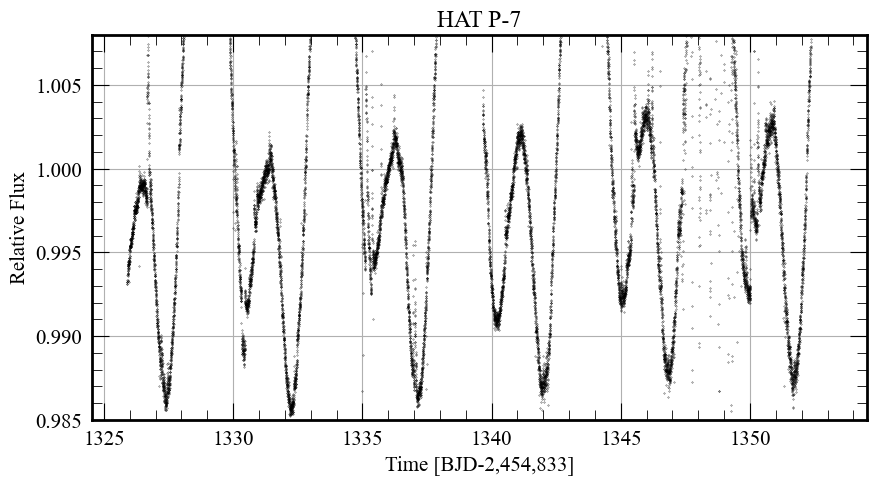

In [10]:
plt.figure(figsize=(10, 5))
plt.ylim(0.985, 1.008) 
plt.title("HAT P-7", fontsize=17)
plt.xlabel('Time [BJD-2,454,833]', fontsize=15)
plt.ylabel('Relative Flux', fontsize=15)
plt.minorticks_on()
plt.tick_params(which='major', direction='in', top=True, right=True, bottom=True, length=12, labelsize=15, pad=7)
plt.tick_params(which='minor', direction='in', top=True, right=True, bottom=True, length=7)

plt.plot(filtered_time, filtered_flux/np.median(filtered_flux), '.', c='k', ms=0.5)
plt.grid();

### Synthetic Light Curves

In [11]:
def generate_synthetic_light_curve(time, period, depth, duration, noise_level=0.001, noise_type="gaussian", red_noise_alpha=1.0):
    """
    Generates a synthetic light curve for a transiting exoplanet with a "U-shape" dip and adds noise

    Parameters:
    ==========
    time            : array-like
        - time array over which to generate the light curve
    period          : float
        - orbital period of the exoplanet (in days)
    depth           : float
        - fractional dip in flux during a transit (e.g., 0.01 for 1%)
    duration        : float
        - duration of each transit (in days)
    noise_type      : str
        - type of noise to add ("gaussian", "white", or "red")
    noise_level     : float
        - standard deviation of the noise to be added
    red_noise_alpha : float
        - alpha parameter for red noise (e.g., 1.0 for 1/f noise)

    * Returns a simulated light curve flux values with the specified noise
    """
    # initializing the light curve with baseline flux of 1
    flux = np.ones_like(time)

    # identifying transit times
    transit_centers = np.arange(time[0], time[-1], period)
    
    for center in transit_centers:
        # indices of points within the transit duration
        in_transit = np.abs(time - center) <= (duration / 2)
        
        # parabolic "U-shape" dip
        transit_time = time[in_transit]
        mid_transit = center
        normalized_time = (transit_time - mid_transit) / (duration / 2)
        flux[in_transit] -= depth * (1 - normalized_time**2)

    # adding noise based on the selected type
    if noise_type.lower() == "gaussian":
        flux += np.random.normal(0, noise_level, size=len(time))
    elif noise_type.lower() == "white":
        flux += np.random.normal(0, noise_level, size=len(time))
    elif noise_type.lower() == "red":
        red_noise = generate_red_noise(len(time), alpha=red_noise_alpha, std=noise_level)
        flux += red_noise
    else:
        raise ValueError("Invalid noise type. Choose 'gaussian', 'white', or 'red'.")

    return flux


def generate_red_noise(size, alpha=1.0, std=0.001):
    """
    * creates a correlated noise signal that mimics the statistical properties of red noise

    Parameters:
    ==========
    size  : int
        - length of the noise array
    alpha : float
        - power spectrum slope (1/f^alpha)
    std   : float
        - standard deviation of the noise

    * Returns a generated red noise
    """
    # generates the positive frequencies associated with the size of the time-series data
    freqs = np.fft.rfftfreq(size)  
    # avoid division by zero at f = 0
    freqs[0] = 1e-6  
    # 1/f^alpha power spectrum 
    # frequencies with lower values contribute more to the power for larger values of α, 
    # leading to correlated, long-term variations in the noise
    power = 1 / (freqs ** alpha)  
    # generates random values (b/w 0 and 1) for each frequency bin
    random_phases = np.exp(2j * np.pi * np.random.random(len(freqs)))
    # creating a complex Fourier spectrum
    spectrum = np.sqrt(power) * random_phases  # amplitude * phase
    
    # converting the frequency-domain spectrum back into the time domain, resulting in a time-series signal
    red_noise = np.fft.irfft(spectrum, n=size)  # inverse FFT to get red noise in time domain
    # normalize to desired std
    red_noise = (red_noise - np.mean(red_noise)) / np.std(red_noise) * std  
    
    return red_noise

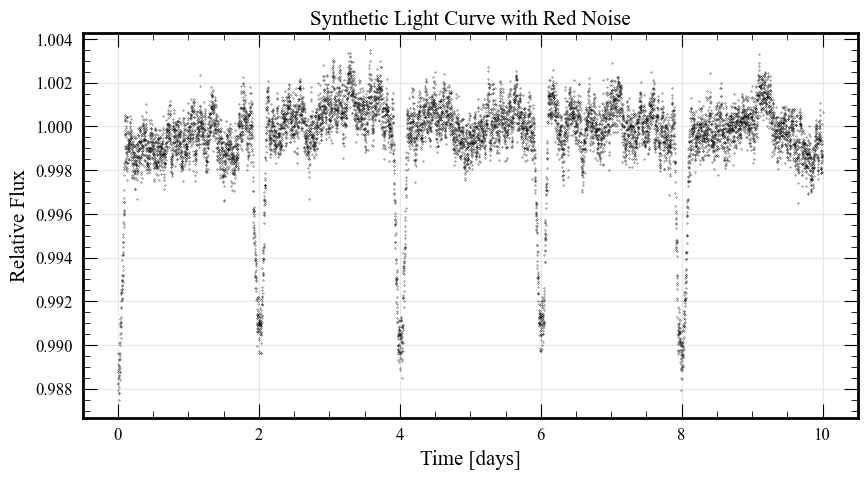

In [12]:
time = np.linspace(0, 10, 10000)  # time array in days
period = 2.0                     # orbital period (in days)
depth = 0.01                     # 1% dip in flux
duration = 0.2                   # 0.2 days transit duration
noise_level = 0.001              # std of Gaussian noise
noise_type = "red"
synthetic_flux = generate_synthetic_light_curve(time, period, depth, duration, noise_level, 
                                                noise_type, red_noise_alpha=1.0)

plt.figure(figsize=(10, 5))
plt.title(f"Synthetic Light Curve with {noise_type.capitalize()} Noise", fontsize=15)
plt.xlabel("Time [days]", fontsize=15)
plt.ylabel("Relative Flux", fontsize=15)
plt.minorticks_on()
plt.tick_params(which='major', direction='in', top=True, right=True, bottom=True, length=10, labelsize=12, pad=7)
plt.tick_params(which='minor', direction='in', top=True, right=True, bottom=True, length=5)
plt.plot(time, synthetic_flux, 'k.', ms=0.5)
plt.grid(alpha=0.3)
plt.show()

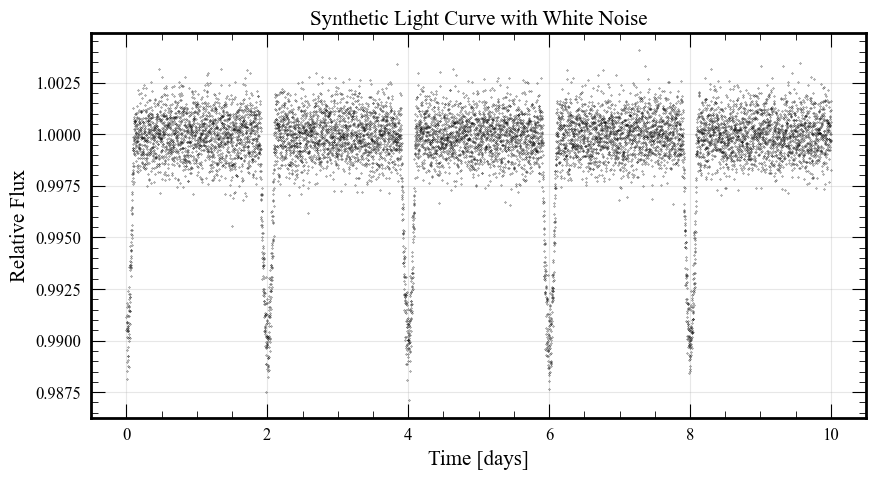

In [13]:
time = np.linspace(0, 10, 10000)  # time array in days
period = 2.0                      # orbital period (in days)
depth = 0.01                      # 1% dip in flux
duration = 0.2                    # 0.2 days transit duration
noise_level = 0.001               # std of Gaussian noise
noise_type = "white"
synthetic_flux = generate_synthetic_light_curve(time, period, depth, duration, noise_level, 
                                                noise_type, red_noise_alpha=1.0)

plt.figure(figsize=(10, 5))
plt.title(f"Synthetic Light Curve with {noise_type.capitalize()} Noise", fontsize=15)
plt.xlabel("Time [days]", fontsize=15)
plt.ylabel("Relative Flux", fontsize=15)
plt.minorticks_on()
plt.tick_params(which='major', direction='in', top=True, right=True, bottom=True, length=10, labelsize=12, pad=7)
plt.tick_params(which='minor', direction='in', top=True, right=True, bottom=True, length=5)
plt.plot(time, synthetic_flux, 'k.', ms=0.5)
plt.grid(alpha=0.3)
plt.show()

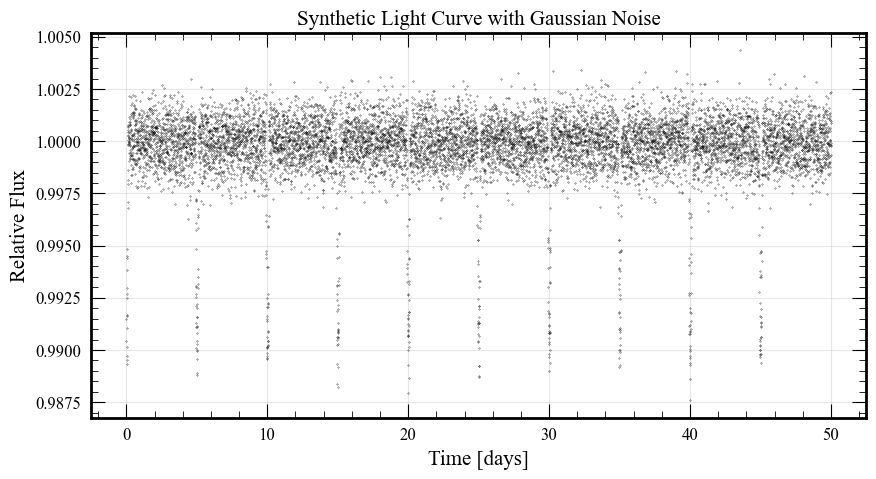

In [14]:
time = np.linspace(0, 50, 10000)  # time array in days
period = 5.0                      # orbital period (in days)
depth = 0.01                      # 1% dip in flux
duration = 0.2                    # 0.2 days transit duration
noise_level = 0.001               # std of Gaussian noise
noise_type = "gaussian"
synthetic_flux = generate_synthetic_light_curve(time, period, depth, duration, noise_level, 
                                                noise_type, red_noise_alpha=1.0)

plt.figure(figsize=(10, 5))
plt.title(f"Synthetic Light Curve with {noise_type.capitalize()} Noise", fontsize=15)
plt.xlabel("Time [days]", fontsize=15)
plt.ylabel("Relative Flux", fontsize=15)
plt.minorticks_on()
plt.tick_params(which='major', direction='in', top=True, right=True, bottom=True, length=10, labelsize=12, pad=7)
plt.tick_params(which='minor', direction='in', top=True, right=True, bottom=True, length=5)
plt.plot(time, synthetic_flux, 'k.', ms=0.5)
plt.grid(alpha=0.3)
plt.show()

### False Transits

In [15]:
def generate_false_transit_light_curve(time, dip_probability, depth_range, duration_range,
                                       noise_type, noise_level, red_noise_alpha=1.0):
    """
    * Generates a synthetic light curve with occasional dips and noise

    Parameters:
    ==========
    time            : array-like
        - time array over which to generate the light curve
    dip_probability : float
        - probability of introducing a random dip at each time point
    depth_range     : tuple (min_depth, max_depth)
        - range of depths for the dips (fractional flux)
    duration_range  : tuple (min_duration, max_duration)
        - range of durations for the dips (in days)
    noise_type      : str
        - type of noise to add ("gaussian", "white", or "red")
    noise_level     : float
        - standard deviation of the noise to be added to the light curve
    red_noise_alpha : float
        - power-law index for the red noise (only used if noise_type is "red")

    * Returns a simulated light curve flux values with occasional dips and noise
    """
    # initializing light curve with baseline flux of 1
    flux = np.ones_like(time)

    for t in time:
        # introduce dips based on probability
        if np.random.rand() < dip_probability:  
            dip_center = t
            dip_duration = np.random.uniform(*duration_range)  
            dip_depth = np.random.uniform(*depth_range)  

            # parabolic dip shape
            in_dip = np.abs(time - dip_center) <= (dip_duration / 2)
            normalized_time = (time[in_dip] - dip_center) / (dip_duration / 2)
            flux[in_dip] -= dip_depth * (1 - normalized_time**2)

    # adding noise to the light curve
    if noise_type.lower() == "gaussian":
        flux += np.random.normal(0, noise_level, size=len(time))
    elif noise_type.lower() == "white":
        flux += np.random.normal(0, noise_level, size=len(time))
    elif noise_type.lower() == "red":
        red_noise = generate_red_noise(len(time), alpha=red_noise_alpha, std=noise_level)
        flux += red_noise
    else:
        raise ValueError("Invalid noise type. Choose 'gaussian', 'white', or 'red'.")

    return flux

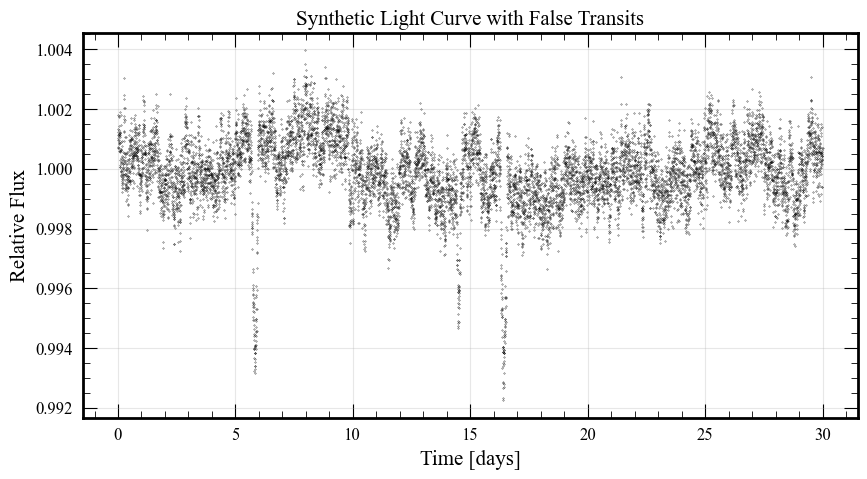

In [16]:
time = np.linspace(0, 30, 10000)  # time (in days), number of datapoints
noise_type = "red"
noise_level = 0.001
dip_probability = 0.0003          # 0.1% transit probability
depth_range = (0.001, 0.008)      # 0.5% ~ 1.0% depth range
duration_range = (0.1, 0.3)       # transit duration (in days)

false_light_curve = generate_false_transit_light_curve(time, dip_probability, depth_range, duration_range,
                                                       noise_type, noise_level, red_noise_alpha=1.0)


plt.figure(figsize=(10, 5))
plt.title("Synthetic Light Curve with False Transits", fontsize=15)
plt.xlabel("Time [days]", fontsize=15)
plt.ylabel("Relative Flux", fontsize=15)
plt.minorticks_on()
plt.tick_params(which='major', direction='in', top=True, right=True, bottom=True, length=10, labelsize=12, pad=7)
plt.tick_params(which='minor', direction='in', top=True, right=True, bottom=True, length=5)
plt.plot(time, false_light_curve, 'k.', ms=0.5)
plt.grid(alpha=0.3)
plt.show()

### ML method: (RNN & LSTM)
Recurrent Neural Networks & Long Short term memory

In [17]:
import numpy as np

time = np.arange(0, 30, 0.01) #time array: example 0 to 30 days with 0.01 day-intervals

### Generating Light curves (false and periodic) with functions from training data

In [47]:
num_curves = 100  #total light curves (50 false, 50 periodic)
raw_data = []
labels = []  #0 for false transits, 1 for periodic transits

for _ in range(num_curves // 2):
    raw_data.append(generate_false_transit_light_curve(
        time=time,
        dip_probability=0.02,
        depth_range=(0.01, 0.05),
        duration_range=(0.1, 0.5),
        noise_type="gaussian",
        noise_level=0.01
    ))
    labels.append(0)  #false transit

for _ in range(num_curves // 2):
    raw_data.append(generate_synthetic_light_curve(
        time=time,
        period=5,
        depth=0.02,
        duration=0.2,
        noise_type="red",
        noise_level=0.005,
        red_noise_alpha=1.5
    ))
    labels.append(1)  #periodic transit

raw_data = np.array(raw_data)
labels = np.array(labels)
print(raw_data.shape)  #output should be (num_curves, len(time))

(100, 3000)


In [46]:
print(raw_data)

[[0.54292797 0.82141846 0.75270261 ... 0.63006169 0.69285778 0.77504059]
 [0.69137145 0.8646579  0.81894286 ... 0.84808772 0.67467546 0.6826912 ]
 [0.88336271 0.73891963 0.66104721 ... 0.6504694  0.7498394  0.91786304]
 ...
 [0.04142691 0.06029694 0.09312914 ... 0.59982681 0.58186004 0.53206804]
 [0.44761157 0.42220844 0.45929748 ... 0.92735159 0.90547646 0.90145855]
 [0.31614514 0.27257337 0.27224803 ... 0.77028247 0.80894382 0.840865  ]]


In [20]:
#labels: 0 for false transits, 1 for true transits
labels = np.array([0] * (num_curves // 2) + [1] * (num_curves // 2))

### Normalizing Light Curves

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
raw_data = scaler.fit_transform(raw_data.T).T  #normalize each curve individually

In [22]:
#save the dataset
np.save("light_curves.npy", raw_data)
np.save("labels.npy", labels)

#use raw_data and labels for training

In [2]:
pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/6d/69/9999c2d9e8a3b08dfcfc7e9259a05fb1da5f700936091d2eb4a7985c2776/tensorflow-2.16.2-cp311-cp311-macosx_10_15_x86_64.whl.metadata
  Using cached tensorflow-2.16.2-cp311-cp311-macosx_10_15_x86_64.whl.metadata (4.1 kB)
Using cached tensorflow-2.16.2-cp311-cp311-macosx_10_15_x86_64.whl (259.6 MB)
Note: you may need to restart the kernel to use updated packages.


### Splitting data set

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(raw_data, labels, test_size=0.2, random_state=42)

In [29]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  #to add feature dimension
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [31]:
print(X_train.shape)  #(num_samples, time_steps, features)

(80, 3000, 1)


### Define the RNN Model
Recurrent Neural Network (RNN) with LSTM layers for sequential time-series classification.

In [33]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  #Binary classification
])

/Users/dimnaprado7/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Reshaping Data for RNN (requires 3-D input):
`(samples, timesteps, features)`

In [35]:
#reshape data for RNN (features=1 for flux values)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  #20% validation from training set
    epochs=10,             #number of training epochs
    batch_size=32,         #batch size
    verbose=2              #to Display training progress
)

Epoch 1/10
2/2 - 24s - 12s/step - accuracy: 0.5000 - loss: 0.6926 - val_accuracy: 0.3750 - val_loss: 0.7052
Epoch 2/10
2/2 - 13s - 7s/step - accuracy: 0.5469 - loss: 0.6829 - val_accuracy: 0.4375 - val_loss: 0.7061
Epoch 3/10
2/2 - 12s - 6s/step - accuracy: 0.5000 - loss: 0.6867 - val_accuracy: 0.5000 - val_loss: 0.7033
Epoch 4/10
2/2 - 14s - 7s/step - accuracy: 0.5469 - loss: 0.6819 - val_accuracy: 0.4375 - val_loss: 0.7064
Epoch 5/10
2/2 - 12s - 6s/step - accuracy: 0.5625 - loss: 0.6911 - val_accuracy: 0.4375 - val_loss: 0.7049
Epoch 6/10
2/2 - 13s - 6s/step - accuracy: 0.5625 - loss: 0.6832 - val_accuracy: 0.5000 - val_loss: 0.7003
Epoch 7/10
2/2 - 11s - 6s/step - accuracy: 0.5469 - loss: 0.6903 - val_accuracy: 0.5000 - val_loss: 0.6993
Epoch 8/10
2/2 - 12s - 6s/step - accuracy: 0.5938 - loss: 0.6868 - val_accuracy: 0.4375 - val_loss: 0.7038
Epoch 9/10
2/2 - 15s - 7s/step - accuracy: 0.6250 - loss: 0.6770 - val_accuracy: 0.5000 - val_loss: 0.7041
Epoch 10/10
2/2 - 12s - 6s/step - ac

### Evaluating the Model's performance

In [42]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6000 - loss: 0.6835
Test Accuracy: 0.60


### Runnning some Visusls

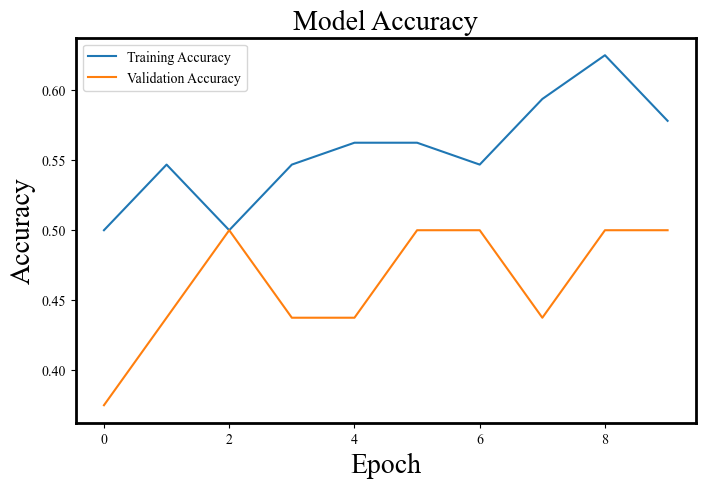

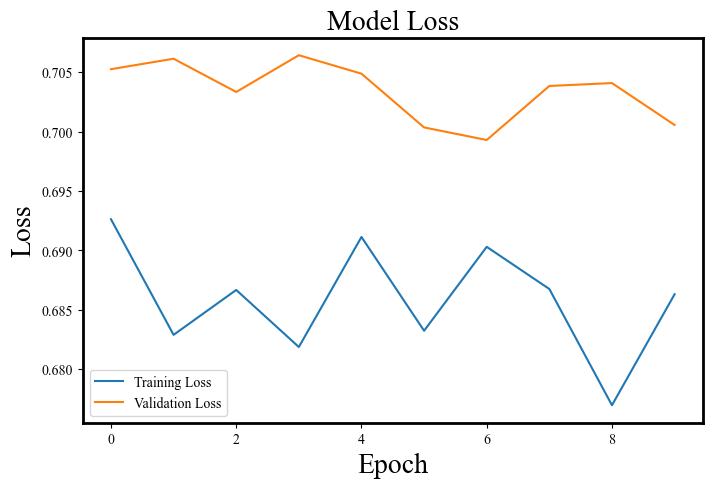

In [43]:
import matplotlib.pyplot as plt

#plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

#plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

### making predictions

In [44]:
predictions = model.predict(X_test)  #outputs probabilities
predicted_classes = (predictions > 0.5).astype(int)  #convert to binary classes

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [48]:
print(predictions)
print(predicted_classes)

[[0.51035434]
 [0.5072711 ]
 [0.4929567 ]
 [0.4455128 ]
 [0.46572602]
 [0.4575942 ]
 [0.46686363]
 [0.48145103]
 [0.53336865]
 [0.50234115]
 [0.4663332 ]
 [0.49191788]
 [0.4680692 ]
 [0.54099786]
 [0.5019595 ]
 [0.48524496]
 [0.47633284]
 [0.49034753]
 [0.48375863]
 [0.4783171 ]]
[[1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [45]:
model.save("exoplanet_classifier_rnn.h5")